### CEG 4900 Trustworthy Machine Learning - Lab Assignment 1

# <center>Adversarial Attacks</center>

### 1. Overview
The learning objective of this lab assignment is for students to understand adversarial attacks and defenses, including how to train a simple multi-class classification model (softmax regression) and a convolutional neural network for image classification, and how to perform adversarial attacks gainst these models.

#### Lecture notes. 
Detailed coverage of these topics can be found in the following:
<li>Machine Learning Basics</li>
<li>Evaluation Metrics for Classification</li>
<li>Simple Feature-Space Adversarial Attack</li>
<li>Gradient-based Adversarial Attack</li>

#### Code demonstrations.
<li>Code-Simple Feature-Space Adversarial Attack.ipynb</li>
<li>Code-Gradient-based Adversarial Attack (FGSM).ipynb</li>

### 2. Submission
You need to submit a detailed lab report with code, running results, and answers to the questions. If you submit <font color='red'>a jupyter notebook (“Firstname-Lastname-4900-Lab1.ipynb”)</font>, please fill in this file directly and place the code, running results, and answers in order for each question. If you submit <font color='red'>a PDF report (“Firstname-Lastname-4900-Lab1.pdf”) with code file (“Firstname-Lastname-4900-Lab1.py”)</font>, please include the screenshots (code and running results) with answers for each question in the report.  

### 3. Questions (50 points)

#### Preparations: import the required libraries and define functions

Please run the following cell to import all the required libraries and define some necessary functions before complete the coding questions.

In [2]:
#Put all the libraries here
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


import matplotlib as mpl
import matplotlib.pyplot as plt


#Define the training function
def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))

#Define the test function for test_dataloader
def test(model, test_dataloader):
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            _, test_predicted = torch.max(predictions.data, 1)
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    print('Test accuracy: %.4f' % (test_correct / test_total))
    
    return y_test, y_pred

#Define the function that returns a predicted label for single input sample
def predict_label(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        _, predicted_label = torch.max(prediction.data, 1)
    
    return predicted_label

#Define the function that returns predicted probabilities for single input sample
def predict_probabilities(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        predicted_probabilities = torch.softmax(prediction, dim=1).squeeze(0)
    
    return predicted_probabilities

#Define the function that returns model weight vector that is used to predict the target_label
def weight_vector(model, target_label):
    model.eval()
    with torch.no_grad():
        weights = list(model.parameters())[0]
    
    return weights[target_label]

#Define the function that plots the given images
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

## <font color='blue'>Simple Feature-space Adversarial Attack</font>

#### Load and preprocess the `Wine Recognition` data

In Question 1, Question 2, Question 3, and Question 4, you will be using the `Wine Recognition Dataset` to train a simple multi-class classification (softmax regression) model to predict the `class` of a given wine (`0: class_0, 1: class_1, 2: class_2`), and perform a feature-space adversarial attack against this trained classification model. First, please run the following cell to load the dataset and convert the data to PyTorch tensors.

In [3]:
#Load wine recognition dataset
wine = load_wine()

#Assign features and labels to X and y
X, y = wine.data, wine.target
#Suppress scientific notation
np.set_printoptions(suppress=True)

#Class names
print("Class names: ", wine.target_names)
#Feature names
print("Feature names: ", wine.feature_names)
#Feature number
print("Number of Features: ", X.shape[1])

#Split the data into two sets: 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset for training and testing, respectively
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders: here, we use mini-batch gradient descent, so need to specify the batch size
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Class names:  ['class_0' 'class_1' 'class_2']
Feature names:  ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Number of Features:  13


#### Question 1 (7 points):  
**First, set up the hyperparameters, and then define a `MultiClassification` to construct a single-layer multi-class classification model (softmax regression). Note: the number of features is 13 and the number of classes is 3** 

**After that, implement function `answer_one( )` to instantiate a model from the defined `MultiClassification`, call the pre-defined function `train(epoch, model, train_dataloader, optimizer, lossfunction)` to train this model, and call the pre-defined function `test(model, test_dataloader)` to evaluate the trained model. Also, use the returned `y_test` and `y_pred` to calculate micro F1 score and macro F1 score.** 

In [4]:
#Define a class MultiClassification to construct a single-layer multi-class classification model
class MultiClassification(nn.Module):
    def __init__(self):
        super(MultiClassification, self).__init__()
        #Code here: define a fully-connected layer
        #The input is the number of features and the output is the number of classes
        #Set bias as False
        self.fc = nn.Linear(in_features=13, out_features=3, bias=False)
    
    def forward(self, x):
        #Code here: set up the forward calculation
        y = self.fc(x)
        
        return y

#Set up the hyperparameters    
torch.manual_seed(42)

#Code here: based on your computing resources, assign epochs as a number in the range of [30, 50]
epochs = 40                      
learning_rate = 0.01                 
weight_decay = 5e-4                 
lossfunction = nn.CrossEntropyLoss()

def answer_one():
    #Code here: instantiate a model from the defined MultiClassification  
    model = MultiClassification()
    
    #Code here: specify the Adam optimizer used for mini-batch gradient descent for model training
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
    
    #Train the model
    for epoch in range(1, epochs + 1):
        #Code here: call train() function for model training: you need to pass the corresponding parameters to this function
        train(epoch, model, train_dataloader, optimizer, lossfunction)
    
    #Test the model: 
    #Code here: call test() function to evaluate the trained model: you need to pass the corresponding parameters to this function
    y_test, y_pred = test(model, test_dataloader)
    
    #Code here: use y_test and y_pred to calculate the macro F1 and micro F1 using sklearn function
    macrof1 = f1_score(y_test, y_pred, average = 'macro')
    microf1 = f1_score(y_test, y_pred, average = 'micro')
    
    return model, macrof1, microf1

#Run your function in the cell to return the results
model, macrof1, microf1 = answer_one()

epoch (1): Train accuracy: 0.3233, loss: 3.954
epoch (2): Train accuracy: 0.4286, loss: 1.167
epoch (3): Train accuracy: 0.5564, loss: 0.635
epoch (4): Train accuracy: 0.5564, loss: 0.314
epoch (5): Train accuracy: 0.6992, loss: 0.153
epoch (6): Train accuracy: 0.6692, loss: 0.123
epoch (7): Train accuracy: 0.6391, loss: 0.103
epoch (8): Train accuracy: 0.6842, loss: 0.104
epoch (9): Train accuracy: 0.7068, loss: 0.088
epoch (10): Train accuracy: 0.7143, loss: 0.088
epoch (11): Train accuracy: 0.6917, loss: 0.095
epoch (12): Train accuracy: 0.6992, loss: 0.114
epoch (13): Train accuracy: 0.6992, loss: 0.119
epoch (14): Train accuracy: 0.7444, loss: 0.078
epoch (15): Train accuracy: 0.7218, loss: 0.073
epoch (16): Train accuracy: 0.7895, loss: 0.056
epoch (17): Train accuracy: 0.7594, loss: 0.058
epoch (18): Train accuracy: 0.7970, loss: 0.084
epoch (19): Train accuracy: 0.7594, loss: 0.073
epoch (20): Train accuracy: 0.7444, loss: 0.057
epoch (21): Train accuracy: 0.8346, loss: 0.058
e

#### <font color='red'>Answer 1 (double click here to answer the questions in this cell):</font>  
The number of epochs you used for softmax regression training is: ( 40 ) <br>
The test accuracy is: ( 0.9556 ) <br>
The test macro f1 score is: ( 0.9023 ) <br>
The test micro f1 score is: ( 0.025 )

#### Randomly select an test input from test_dataset to perturb and select a target label to attack

Please run the following cell to select a random test input from test_dataset and a target label, which will be used for the following questions to perform simple feature-space adversarial attack.

In [5]:
#Set the random seed
np.random.seed(42)

#Number of test samples
number_of_samples = len(test_dataset)
#Get a random index from [0, number_of_samples)
index = np.random.randint(number_of_samples)

#Select the test input to perturb
test_input = test_dataset[index][0]
test_input_label = test_dataset[index][1]

#Here, we perform targeted adversarial attack: change the original_label to the target_label
original_label = test_input_label.item() #class_1
target_label = 2 #class_2

print("The index of the test input: ", index)
print("Test input feature vector: ", test_input)
print("Test input original label: ", original_label, wine.target_names[original_label])
print("Target label: ", target_label, wine.target_names[target_label])

The index of the test input:  38
Test input feature vector:  tensor([1.2370e+01, 1.0700e+00, 2.1000e+00, 1.8500e+01, 8.8000e+01, 3.5200e+00,
        3.7500e+00, 2.4000e-01, 1.9500e+00, 4.5000e+00, 1.0400e+00, 2.7700e+00,
        6.6000e+02])
Test input original label:  1 class_1
Target label:  2 class_2


#### Question 2 (7 points): 

**Implement the function `answer_two(k)` to search for a good instance to guide the simple feature-space adversarial attack, where you need to assign the value of `k` first to specify the number of top target samples close to decision boundary you would like to collect for good instance searching.**  

In [12]:
#Code here: assign k as any integer in the range of [5,10]
k = 7

def answer_two(k):
    #Obtain all the test samples with the target label
    target_samples = [] #Test samples that are predicted as the target label
    target_probs = []   #The prediction probabilities for each test sample
    
    for sample, true_label in test_dataset:
        #Code here: using predict_label() to predict label for each sample (note: please use sample.unsqueeze(0) to ensure batch dimensition)
        predicted_label = predict_label(model, sample.unsqueeze(0))
        #Code here: using predict_probabilities() to predict probabilities for each sample (note: please use sample.unsqueeze(0) to ensure batch dimensition)
        predicted_proabilities = predict_probabilities(model, sample.unsqueeze(0))

        #Code here: append sample amd its proabilities to target_samples and target_probs if the predicted_label is target_label
        if predicted_label == target_label:
            target_samples.append(sample)
            target_probs.append(predicted_proabilities)

    target_samples = torch.stack(target_samples)
    target_probs = torch.stack(target_probs)
    
    #Code here: rank target samples by highest probability for the original label
    closest_to_boundary_indices = torch.argsort(torch.max(target_probs, dim=1).values)
    
    #Code here: find the indices of top k target samples that are closest to decision boundary
    top_k_boundary_indices = closest_to_boundary_indices[:k]
    
    #Code here: calculate manhattan distance (L1 distance) between test_input and target_samples
    distances = torch.sum(torch.abs(target_samples - test_input), dim=1)
    
    #Code here: find the indices of target samples that have shortest distance to the test_input 
    nearest_neighbors_indices = torch.argsort(distances)
    
    #The good instance is initialized as the nearest neighbor
    good_instance = target_samples[nearest_neighbors_indices[0]]

    #Code here: find a good instance: one of the test_input's nearest neighbors that is among top k target samples close to decision boundary
    for i in nearest_neighbors_indices:
        if i in top_k_boundary_indices:
            good_instance = target_samples[i]
            break
        
    return good_instance

#Run your function in the cell to return the results
good_instance = answer_two(k)
print(good_instance)

tensor([1.2930e+01, 2.8100e+00, 2.7000e+00, 2.1000e+01, 9.6000e+01, 1.5400e+00,
        5.0000e-01, 5.3000e-01, 7.5000e-01, 4.6000e+00, 7.7000e-01, 2.3100e+00,
        6.0000e+02])


#### <font color='red'>Answer 2 (double click here to answer the questions in this cell):</font>  
The k you used to search for top target samples close to decision boundary is: ( 7 ) <br>
The good instance you found for guidance is: ( 2930e+01 )

#### Question 3 (5 points): 

**Implement the function `answer_three( )` to find feature indices in descending order of feature importance, such that we can use greedy search method to perturb these features from the most important one to the least important one. When you have a feature index, you can get its feature name using `wine.feature_names[feature_index]`. For example, if the feature index is 5, then its feature name is `wine.feature_names[5]`.**

In [15]:
def answer_three():
    #Code here: use weight_vector() to extract feature importances for the target label which can be quantified by the weight vector to predict the target label
    featue_importances = weight_vector(model, target_label)

    #Code here: find the indices of features from the most important to the least important 
    featue_importances_indices = torch.argsort(featue_importances, descending = True).tolist()
    
    #Code here: extract the most important feature (name)
    most_important = wine.feature_names[featue_importances_indices[0]]
    
    #Code here: extract the least important feature (name)
    least_important = wine.feature_names[featue_importances_indices[-1]]
    
    return featue_importances_indices, most_important, least_important

#Run your function in the cell to return the results
featue_importances_indices, most_important, least_important = answer_three()
print(featue_importances_indices, most_important, least_important)

[9, 7, 1, 2, 4, 12, 3, 0, 11, 10, 5, 8, 6] color_intensity flavanoids


#### <font color='red'>Answer 3 (double click here to answer the questions in this cell):</font>  
The feature indices in descending order of feature importance are: ( 9, 7, 1, 2, 4, 12, 3, 0, 11, 10, 5, 8, 6 ) <br>
The most important feature is (fill in its feature name): ( color_intensity ) <br>
The least important feature is (fill in its feature name): ( flavanoids )

#### Question 4 (8 points): 

**Implement the function `answer_four( )` to perturb the `test_input` by directly updating the value of a specific feature in the original test input to the value of that in the good instance.**

In [22]:
adversarial_example = test_input.clone()

def answer_four():
    #Code here: perturb the features from the most important one to the least important one
    for feature in featue_importances_indices:
        adversarial_example[feature] = good_instance[feature]

    #Code here: calculate the size of perturbation
    perturbation_size = torch.sum(torch.abs(adversarial_example - test_input)).item()
    
    return adversarial_example, perturbation_size

#Run your function in the cell to return the results
adversarial_example, perturbation_size = answer_four()
print(adversarial_example)
print(perturbation_size)

tensor([1.2930e+01, 2.8100e+00, 2.7000e+00, 2.1000e+01, 9.6000e+01, 1.5400e+00,
        5.0000e-01, 5.3000e-01, 7.5000e-01, 4.6000e+00, 7.7000e-01, 2.3100e+00,
        6.0000e+02])
80.95000457763672


#### <font color='red'>Answer 4 (double click here to answer the questions in this cell):</font>  
The adversarial example is: ( 2930e+01 ) <br>
The size of perturbation is: ( 80.95 ) <br>
Based on the previous steps, please summarize why we need to find a good instance and use feature importances to facilitate adversarial attack: ( Finding a good instance and using feature importance is useful because it helps us to guide adversarial attacks by honing in on the most impactful features for the attack which increases effectiveness while also minimizing the scale of perturbations. This allows for the attack to be more subtle and harder for a user to detect when it is occurring. ), and the advantage and disadvantage are: ( The advantage(s) are: Efficiency, Mininmal Perturbation, and Higher Success Rate. The disadvantage(s) are: Dependency on Model Explainability, Transferability Issues, and Computational Overhead. ).

## <font color='blue'>Gradient-based Adversarial Attack</font>

#### Load and preprocess the `Fashion-MNIST` data

In Question 5 and Question 6, you will be using the `Fashion-MNIST` to train a convolutional neural network model to predict the fashion product name of a given image, and perform a gradient-based adversarial attack against this trained fashion product image classification model. First, download the `Fashion-MNIST` data directly from PyTorch and convert the dataset into Tensor used by PyTorch. 

Loading `Fashion-MNIST` data of 70,000 images may take some time. The downloaded `Fashion-MNIST` data file will be stored in  `data` folder under the same directory with your notebook/python file.

The size of each image in `Fashion-MNIST` data is 28x28. Each image is fed as 28x28 matrix to convolutional neural network directly.

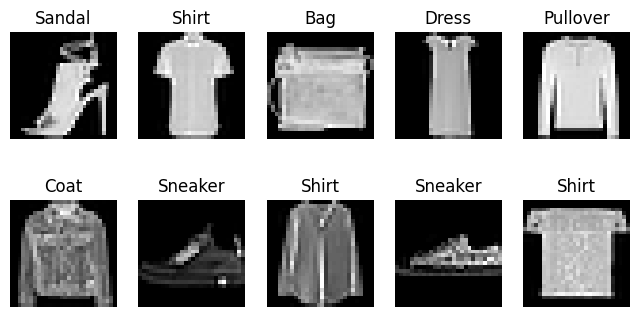

In [23]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the Fashion-MNIST data directly from PyTorch
#The downloaded datasets are stored in data folder under the same folder with this jupyter notebook file
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Plot some Fashion-MNIST examples
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
dataiter = iter(train_dataloader)
samples = next(dataiter)
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Question 5 (7 points):  
**First, set up the epochs (all the other hyperparameters are defined in Question 1), and then define a class `CNN` to construct all the layers in the convolutional neural network.** 

**After that, implement function `answer_five( )` to instantiate a CNN model from the defined `CNN`, call the pre-defined function `train(epoch, model, train_dataloader, optimizer, lossfunction)` to train the CNN model, and call the pre-defined function `test(model, test_dataloader)` to evaluate the trained CNN model. Also, use the returned `y_test` and `y_pred` to calculate micro F1 score and macro F1 score.**

In [25]:
#Set the random seed
torch.manual_seed(42)

#Code here: based on your computing resources, assign epochs as a number in the range of [5, 10]  
epochs = 7                

#Code here: define a class CNN to construct all the layers in the convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)                                   #Convolution: 1 input channel to 10 channels with kernel_size 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)                                   #Convolution: 10 channels to 20 channels with kernel_size 5
        self.fc1=nn.Linear(320, 50)                                   #Fully-connected layer: 320 neurons to 50 neurons
        self.fc2=nn.Linear(50, 10)                                   #Fully-connected layer: 50 neurons to 10 neurons

    def forward(self, x):
        x = F.relu(self.conv1(x))                                   #Use ReLU as activation function for the convolution layer 
        x = F.max_pool2d(x, 2)                                   #Apply max_pooling on the output of the convolution layer with size 2
        x = F.relu(self.conv2(x))                                   #Use ReLU as activation function for the convolution layer
        x = F.max_pool2d(x, 2)                                   #Apply max_pooling on the output of the convolution layer with size 2
        x = x.view(x.size(0), -1)                                   #Flatten all channels to a single vector
        x = F.relu(self.fc1(x))                                   #Use ReLU as activation function for the fully-connected layer
        x = self.fc2(x)                                   #Obtain the final output with 10 neurons for 10 classes
        return x

def answer_five():    
    #Code here: instantiate a CNN model from the defined CNN class  
    model = CNN()
    
    #Code here: specify the optimizer used for mini-batch gradient descent for model training
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
    
    #Train the model
    for epoch in range(1, epochs + 1):
        #Code here: call train() function for model training: you need to pass the corresponding parameters to this function
        train(epoch, model, train_dataloader, optimizer, lossfunction)
    
    #Test the model: 
    #Code here: call test() function to evaluate the trained model: you need to pass the corresponding parameters to this function
    y_test, y_pred = test(model, test_dataloader)
    
    #Code here: use y_test and y_pred to calculate the macro F1 and micro F1 using sklearn function
    macrof1 = f1_score(y_test, y_pred, average = 'macro')
    microf1 = f1_score(y_test, y_pred, average = 'micro')
    
    return model, macrof1, microf1

#Run your function in the cell to return the results
model, macrof1, microf1 = answer_five()
print(macrof1, microf1)

epoch (1): Train accuracy: 0.8162, loss: 0.008
epoch (2): Train accuracy: 0.8622, loss: 0.006
epoch (3): Train accuracy: 0.8668, loss: 0.006
epoch (4): Train accuracy: 0.8720, loss: 0.005
epoch (5): Train accuracy: 0.8732, loss: 0.005
epoch (6): Train accuracy: 0.8739, loss: 0.005
epoch (7): Train accuracy: 0.8761, loss: 0.005
Test accuracy: 0.8703
0.8707016853789605 0.8703


#### <font color='red'>Answer 5 (double click here to answer the questions in this cell):</font>  
The number of epochs you used for CNN training is: ( 7 ) <br>
The test accuracy is: ( 0.8703 ) <br>
The test macro f1 score is: ( 0.8707 ) <br>
The test micro f1 score is: ( 0.8703 )

#### Question 6 (8 points):
**Based on the convolutional neural network `model` trained in Question 5, please implement a fast gradient sign method attack in function `answer_six(epsilon, image_input, true_label)`, and then based on your implementation, answer the corresponding question.**

In [26]:
def answer_six(epsilon, image_input, true_label):
    #Set requires_grad attribute of image_input tensor as true, which will be used to get the gradient
    image_input.requires_grad = True
    
    #Code here: pass the input image through the trained model to get the output
    prediction = model(image_input)

    #Code here: calculate the loss
    loss = lossfunction(prediction, torch.tensor([true_label]))

    #Code here: zero all existing gradients
    model.zero_grad()

    #Code here: calculate gradients of loss in backward pass
    loss.backward()

    #Code here: obtain the gradient regarding input image
    image_input_grad = image_input.grad.data

    #Perform FGSM attack
    #Code here: obtain the sign of the gradient
    sign_grad = image_input_grad.sign()

    #Code here: generate the perturbed image by adding the perturbation with epsilon and sign of gradient to the input image
    perturbed_image = image_input + epsilon * sign_grad

    #Code here: add clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image 

#### <font color='red'>Answer 6 (double click here to answer the questions in this cell):</font>  
Based on the previous implementation, please summarize the steps of adversarial attack using fast gradient sign method: ( The steps of an adversarial attack using the fast gradient sign method are as follows: 1. Enable gradient tracking for the input image. 2. Pass the input image through the model used to get predictions. 3. Compute the loss between the prediction and the true label. 4. Perform backwards propagation to obtain the gradients with respect to the input. 5. Take the sign of the gradient to determine the direction of the maximum loss increase. 6. Generate the adversarial example by adding epsilon multiplied by the gradient sign to the input. 7. Clip the pixel values to maintain valid image ranges. ), and explain why FGSM uses the sign of the gradient instead of the raw gradient: ( FGSM uses the sign of the gradient instead of the raw gradient because when the sign is used, it ensures that the perturbation direction is consistent, FGSM can control the magnitude with the epsilon, and using the sign if more computationally beneficial when compared to just using the raw gradient. ).

#### Question 7 (8 points):
**Implement function `answer_seven( )` to call the FGSM function implemented in `answer_six(epsilon, image_input, true_label)` to generate adversarial examples, and also evaluate how varying `epsilon` on the attack performance and the input images.**

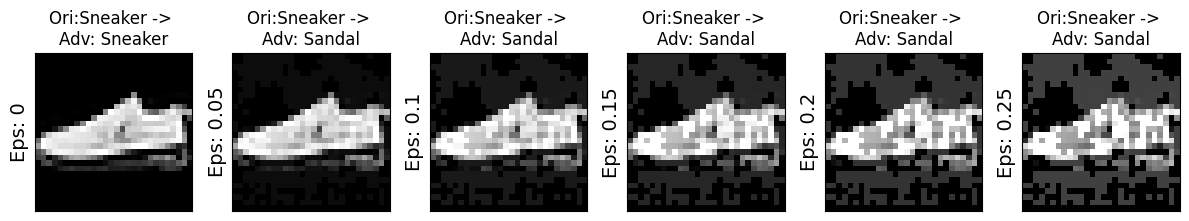

In [27]:
#epsilons for the size of perturbation
epsilons = [0, .05, .1, .15, .2, .25]

#Choose a random test image as input
#Set the random seed
np.random.seed(42)

#Number of test samples
number_of_images = len(test_dataset)
#Get a random index from [0, number_of_samples)
image_index = np.random.randint(number_of_samples, size=1)

#Select the test input to perturb
test_images = torch.stack([test_dataset[i][0] for i in image_index])
test_imagelabels = torch.tensor([test_dataset[i][1] for i in image_index])

def answer_seven():
    adversarial_examples = []
    true_labels = []
    adv_labels = []

    for epsilon in epsilons:
        #Code here: call answer_six() to generate the perturbed image: you need to pass the corresponding parameters to this function
        perturbed_image = answer_six(epsilon, test_images[0].unsqueeze(0), test_imagelabels[0].item())
        #Code here:: use predict_label() to classify the perturbed image
        adv_label = predict_label(model, perturbed_image)
    
        adversarial_examples.append(perturbed_image.detach().numpy())
        true_labels.append(test_imagelabels[0].item())
        adv_labels.append(adv_label)
    
    return adversarial_examples, true_labels, adv_labels

#Run your function in the cell to return the results
adversarial_examples, true_labels, adv_labels = answer_seven()

#Plot adversarial example at each epsilon
plt.figure(figsize=(12,20))
for i in range(len(epsilons)):
    plt.subplot(1, len(epsilons), i + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
    orig, adv, ex = true_labels[i], adv_labels[i], adversarial_examples[i][0].squeeze(0)
    plt.title("Ori:{} -> \nAdv: {}".format(class_names[orig], class_names[adv]))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

#### <font color='red'>Answer 7 (double click here to answer the questions in this cell):</font>  
The original label name is: ( Sneaker ) <br>
After performing adversarial attack using fast gradient sign method, you get a successful adversarial example when the epsilon is: ( 0.05 ) <br>
The adversarial label name is: ( Sandal ) <br>
Please summarize the impact of perturbations with different epsilons on the attack performance and the visual quality of the input image: ( The impact of perturbations with different epsilons on the attack performance and the visual quality of the input image is that when using a small epsilon, small perturbations that are not visible to the human eye but can still cause the model to misclassify an image, allowing for a subtle and effective attack. A moderate epsilon allows for more noticable perturbations with a higher likelihood of the model misclassifying an image, allowing for a more balanced stance on effectiveness and image disortion. A large epsilon allows for significant visual perturbations to occur, which will reduce the stealth of the attack, but almost gurantee that an image misclassification will occur. ).